---
layout: post
title:  "Painting the Starry Night with Genetic Algorithms: Part One"
short_title: "Genetic Algorithms 1: The Starry Night"
desc: "A gentle introduction to genetic algorithms by recreating painting classics?"
long_desc: "In this tutorial, we'll introduce a simple genetic algorithm to recreate classic art using simply geometry"
date: ###DATE
categories: [tutorial]
tags: [statistics]
loc: ###LOC
permalink: ###LINK 
redirect_from: "/genetic1"

math: true
---


This is what we're going to make in this tutorial. It may not look like much, but then again, this is but the first step into genetic algorithms. If you've guessed that this is the Starry Night (or bothered to read the title, description or anything else), fantastic.

In [64]:
from IPython.display import Video
from IPython.display import Image
Video("genetic1/output.mp4")

!!! img-smaller

The idea behind Genetic Algorithms is simple - each algorithm can be evaluated to get its fitness, and algorithms are mutated, bred and culled, according to their performance. The broad steps of a genetic algorithm are as follows:

1. Start with an initial population
2. Determine the fitness of members of the population
3. Select the fitest members for survival
4. Breed those members (for example, using crossover, which we'll cover next)
5. Mutate them for fun!
6. Continue from step 2

To get us started with genetic algorithms, we are going to forget for now about a population and breeding, instead we shall have a single organism and line of descent, mutating it away as it undergoes mitosis. 

To begin, some necessary imports:

In [47]:
import os
import numpy as np
from numpy.random import choice, random, normal
from colour import Color
import pygame  # Pygame for nice fast drawing
import subprocess ###REMOVE

For the first fun part, we want an _organism_. An organism is an entity with a chromosome, which is a collection of genes. These genes are what we mutate, and the genes express themselves in various ways. In our example, each gene expresses itself as a circle.

Each organism has the ability to mutate. That is, perform mitosis to generate a new organism that is a clone of itself, except with some genes _changed_ in some way. In the implementation below, you can see that when we mutate, we give the option to add or remove a gene, or to change features of existing genes. Of course, we could do these both together, we just have to keep in mind that if we change too much at once, our new organism will probably be a bad fit and get culled immediately.

If you are familiar with MCMC optimisation methods like Metropolis-Hastings, this is us making sure our step size is small enough. If MCMC is something new, ignore this sentence!

In [ ]:
class Organism:
    def __init__(self, genes):
        self.chromosome = np.clip(genes, 0, 1)
        self.visual = None
        self.fitness = None
        
    def mutate(self, mutation_rate=0.01, scale=0.3, add_chance=0.3):
        """ Get a mutated organism given the mutation rates and scale input """
        chromosome = np.copy(self.chromosome)
        n_gene, n_feats = chromosome.shape

        # Here we can add/remove a gene, or mutate an existing one
        if random() > add_chance:
            # Mutate features in our genes
            num_mutations = 1 + int(mutation_rate * chromosome.size)
            # As we mutate more, the size of mutations decreases
            scale2 = scale / num_mutations
            for i in range(num_mutations):
                chromosome[choice(n_gene), choice(n_feats)] += normal() * scale2
        else:
            # Either add or remove a gene
            if random() < 0.3:
                chromosome = np.delete(chromosome, choice(n_gene), axis=0)
            else:
                # When we add, we'll do so by blending two existing genes 
                # and perturbing it. More likely to find a good gene this way.
                a, b = choice(n_gene, 2, replace=False)
                gene = np.atleast_2d(0.5 * (chromosome[a, :] + chromosome[b, :]))
                gene += scale * normal(size=(1, gene.size))
                gene[:, 2] *= 0.2
                chromosome = np.append(chromosome, gene, axis=0)
                
        return Organism(chromosome)
    

After this, we want something that keeps track of our organism, and mutates it, evaluates it, etc. We shall call this a `Population`, even though in our case we just looking at a single `best_organism` to start with.

This a fairly large code block, but it should be fairly straightforward in its logic. If you want the important part, the `step` function at the bottom is main component.

In [56]:
class Population:
    def __init__(self, path):
        """ Load in the reference image and create a surface we can draw on. """
        pygame.init()
        self.ref = pygame.surfarray.pixels3d(pygame.image.load(path))
        w, h, d = self.ref.shape
        self.screen = pygame.Surface((w, h))
        self.screen.fill((255, 255, 255))
        
        self.best_organism = None

    def draw(self, organism):
        """ Draw an organism by expressing each gene in term """
        w, h, d = self.ref.shape
        screen = self.screen.copy()
        for gene in organism.chromosome:
            x, y, size, *hsl = gene
            position = (int(x * w), int(y * h))
            c = tuple(map(lambda x: int(255 * x),  Color(hsl=hsl).rgb))
            pygame.draw.circle(screen, c, position, int((size * 0.3 + 0.01) * w))
        return screen
    
    def spawn(self, complexity=1):
        """ Spawn a new individual with `complexity` genes to start with """
        random_genes = random((complexity, 6))
        self.best_organism = Organism(random_genes)
        self.calc_fitness(self.best_organism)
        
    def calc_fitness(self, organism):
        """ Calculate the fitness of a gene by drawing it and comparing
        it to the reference """
        screen = self.draw(organism)
        diff = pygame.surfarray.pixels3d(screen) - self.ref
        organism.fitness = -np.mean(np.abs(diff)) - 1e-5 * organism.chromosome.size
        organism.visual = screen

    def step(self, time, outdir, rate=0.01, scale=0.1, add_chance=0.3):
        """ Take a step in time by mutating the organism and seeing if its the 
        fittest out there! This will also save out a checkpoint file so we can resume
        evolution, and save out images every 200 steps. """
        o = self.best_organism.mutate(mutation_rate=rate, scale=scale, add_chance=add_chance)
        self.calc_fitness(o)

        if o.fitness > self.best_organism.fitness:
            self.best_organism = o
        
        # Save out the image if we want it
        if time % 200 == 0:
            path = outdir + f"{time // 200:04d}.png"
            pygame.image.save(self.best_organism.visual, path)
            np.save(outdir + "save.npy", self.best_organism.chromosome)


With this population, we can create a handy helper function which points to a reference image, sets an output directup up, and then either loads the checkpoint, or starts anew if its not found!

In [68]:
def evolve(rate, scale, add_chance, steps=1000000):
    pop = Population("genetic1/starry_night.png")
    outdir = f"genetic1/output/"
    os.makedirs(outdir, exist_ok=True)
    save = outdir + "save.npy"
    if os.path.exists(save):
        pop.best_organism = Organism(np.load(save))
        pop.calc_fitness(pop.best_organism)
        start = int(sorted(os.listdir(outdir))[-2][:-4]) * 200
    else:
        pop.spawn(complexity=10)
        start = 0
    for i in range(start, steps):
        pop.step(i, outdir, rate=rate, scale=scale, add_chance=add_chance)

With this all set up, we can now call `evolve` and specify the mutation rate, the scale of the mutations, and the chance that we add or remove a gene in any given mutation.

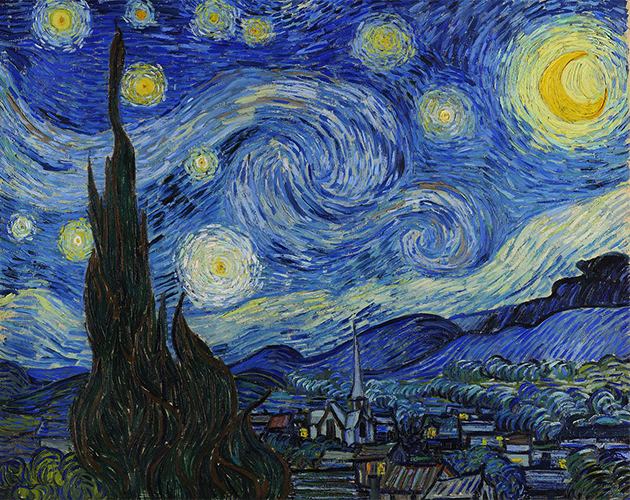

In [69]:
Image("genetic1/starry_night.png")

!!!main

The above is our starting point, so lets see how far we can get using a slow rate of evolution:

In [70]:
# 1% chance of mutation, scale is a normal of std 0.2, and 1% chance to add or remove
evolve(0.01, 0.2, 0.01)

After this has run, we will have a *lot* of PNG files in the output directory. If we fire up good old `ffmpeg` to turn them into a video sequence, this is what we get:

In [71]:
import shutil
outdir = "genetic1/output/"
outdir2 = outdir.replace("output", "processed")
os.makedirs(outdir2, exist_ok=True)
nums = [int(x[:-4]) for x in sorted(os.listdir(outdir)) if "png" in x]
max_step = np.max(nums)
frames = np.unique(np.geomspace(1, max_step, 1200).astype(int))
for i, f in enumerate(frames):
    shutil.copyfile(outdir + f"{f:04d}.png", outdir2 + f"{i:04d}.png")
    if f == frames[-1]:
        shutil.copyfile(outdir + f"{f:04d}.png", "genetic1/final.png")

command = f"ffmpeg -r 60 -i {outdir2}%04d.png -vcodec libx264 -y -filter_complex \"tpad=stop_duration=3:stop_mode=clone\" -crf 23 -movflags faststart -pix_fmt yuv420p {outdir[:-1]}.mp4" ###REMOVE
subprocess.run(command)  ### REMOVE
Video(outdir[:-1] + ".mp4") ###REMOVE

Alright, this all looks interesting...

But...

It took thousands upon thousands of iterations to get us anything like what we want, and even at the end it could be markedly better.

Obviously, it is time to increase the sophistication of our algorithm. [Onto part two](/genetic2)! And for reference, here is our final frame:

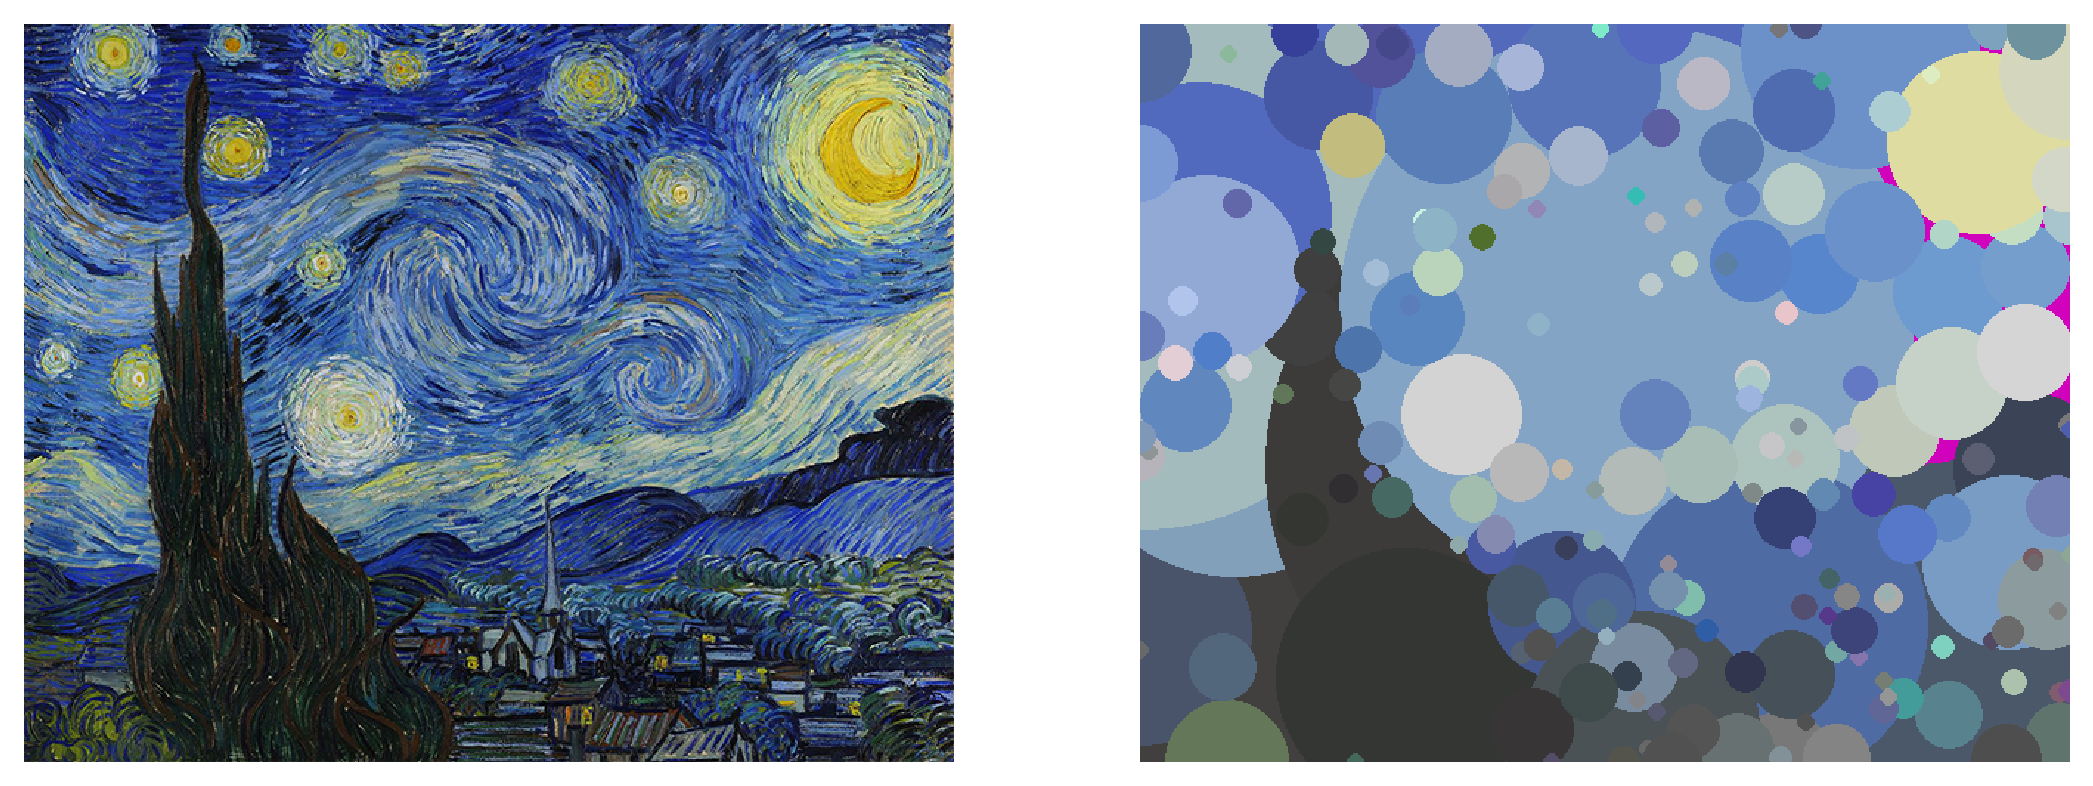

In [80]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

# read images
img_A = mpimg.imread('genetic1/starry_night.png')
img_B = mpimg.imread('genetic1/final.png')

# display images
fig, axes = plt.subplots(ncols=2, figsize=(11 ,8))
axes[0].imshow(img_A);
axes[1].imshow(img_B);
axes[0].axis('off');
axes[1].axis('off');